In [1]:
from tensorflow import keras
from numpy import dstack
from keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
 

In [2]:
path = "wisdm_sampled_segmented.h5"

In [3]:
f = h5py.File(path, 'r')
X = f.get('input')
y = f.get('label') 
#print(type(X))
#print(type(y))
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, test_size=0.3, random_state = 1)

In [4]:
trainy_one_hot = to_categorical(y_train)
valy_one_hot = to_categorical(y_val)
testy_one_hot = to_categorical(y_test)


In [5]:
n_steps, n_length, n_features = 4, 32, 3
X_test.shape

(11936, 128, 3)

## Loading Models:

- **model1: 3levels on CNN (4layers in each)(takes 4input)**

In [6]:
model1 = load_model("Models_h5//model1.h5")

- **model2: 3levels on CNN (4layers in each) , parallaly 1LSTM layer (takes 5inputs)**

In [7]:
model2 = load_model("Models_h5//model2.h5")

- **model3: Timdistributed ConvLSTM(takes 1input)**

In [8]:
model3 = load_model("Models_h5//model3.h5")

- **model4: 2layered LSTM(takes 1input)**

In [9]:
model4 = load_model("Models_h5//model4.h5")

##  Running the member models to make predictions on the validation set, and create a new training set with the resulting predictions

In [15]:
n_steps, n_length, n_features = 4, 32, 3
X_val3 = X_val.reshape((X_val.shape[0], n_steps, n_length,n_features))

In [16]:
stackX_train = None

In [17]:
##Output model1
yhat = model1.predict([X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train =yhat

In [18]:
##Output model2
yhat = model2.predict([X_val,X_val,X_val,X_val,X_val], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [19]:
##Output model3

yhat = model3.predict(X_val3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [20]:
##Output model4
yhat = model4.predict(X_val, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_train = dstack((stackX_train, yhat))

In [21]:
stackX_train.shape

(1, 8355, 4)

In [22]:
stackX_train = stackX_train.reshape((stackX_train.shape[0]*stackX_train.shape[1],stackX_train.shape[2]))

In [23]:
stackX_train.shape####it is the training set of the ensembling classifier

(8355, 4)

In [24]:
y_val.shape

(8355,)

In [25]:
from sklearn.ensemble import RandomForestClassifier
EnsemHAR=RandomForestClassifier(n_estimators= 2000,
 min_samples_split= 9,
 min_samples_leaf= 2,
 max_features='sqrt',
 max_depth=890,
 criterion= 'gini')

In [40]:
from sklearn.model_selection import RandomizedSearchCV 
n_estimators=[int(x) for x in np.linspace(start=200, stop=2000, num=10)]# here we are taking a list of 10 diffrent numbers ranging 
#from 200 -2000 which are the number of decision trees for 10 different model of random forest 
max_features=['auto','sqrt','log2']#discussed before
max_depth=[int(x) for x in np.linspace(10,1000,10)]#10 different max_depth values for 10 different model 
min_samples_leaf = [1,2,4,6,8]
min_samples_split = [1,3,4,5,7,9]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [1, 3, 4, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)

NameError: name 'RandomizedSearchCV' is not defined

In [26]:
y_val_1D=np.ravel(y_val)

In [27]:
EnsemHAR.fit(stackX_train,y_val_1D)


RandomForestClassifier(max_depth=890, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=9, n_estimators=2000)

In [ ]:
rf_randomcv.fit(stackX_train,y_val_1D)

In [54]:
rf_randomcv.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 560,
 'criterion': 'gini'}

In [55]:
ensembler=rf_randomcv.best_estimator_

##  Now evaluate the ensemble on the test set:
#### Create stacked model input dataset as outputs from the ensemble;

In [28]:
stackX_test = None

In [29]:
n_steps, n_length, n_features = 4, 32, 3
X_test3 = X_test.reshape((X_test.shape[0], n_steps, n_length,n_features))

In [30]:
##Output model1
yhat = model1.predict([X_test,X_test,X_test,X_test], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = yhat

In [31]:
##Output model2
yhat = model2.predict([X_test,X_test,X_test,X_test,X_test], verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [32]:
##Output model3

yhat = model3.predict(X_test3, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [33]:
##Output model4
yhat = model4.predict(X_test, verbose=0)
yhat=np.argmax(yhat, axis=-1)
stackX_test = dstack((stackX_test, yhat))

In [34]:
stackX_test.shape

(1, 11936, 4)

In [35]:
stackX_test = stackX_test.reshape((stackX_test.shape[0]*stackX_test.shape[1],stackX_test.shape[2]))

In [36]:
stackX_test.shape

(11936, 4)

In [37]:
predy=EnsemHAR.predict(stackX_test)


In [14]:
predy.shape

NameError: name 'predy' is not defined

In [ ]:
# predy = ensembler.predict(stackX_test)

In [38]:
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_test,predy)
print(cm)
print(acc(y_test,predy))
print(classification_report(y_test,predy))


[[1950    3    6    3    0    0]
 [   0 1992    8    4    0    0]
 [   2    3 1990   66    2    0]
 [   1    0   49 1926    2    0]
 [   0    0    0    0 1952    3]
 [   0    1    0    0    2 1971]]
0.9870140750670241
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1962
         1.0       1.00      0.99      1.00      2004
         2.0       0.97      0.96      0.97      2063
         3.0       0.96      0.97      0.97      1978
         4.0       1.00      1.00      1.00      1955
         5.0       1.00      1.00      1.00      1974

    accuracy                           0.99     11936
   macro avg       0.99      0.99      0.99     11936
weighted avg       0.99      0.99      0.99     11936



In [39]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))

In [40]:
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

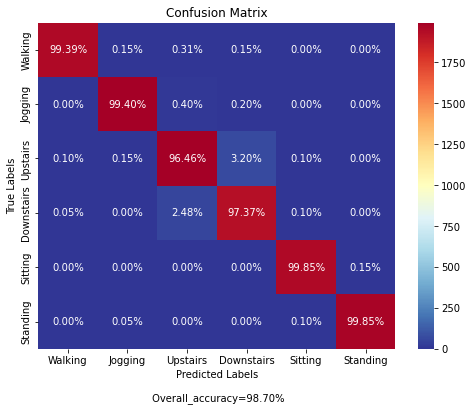

In [41]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_test,predy)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('Metrics//ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

## Plotting of ROC curve

In [42]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc={}

class_number = 6
predy_one_hot=to_categorical(predy)
for i in range(class_number):    
    fpr[i], tpr[i], _ = roc_curve(y_test, predy_one_hot[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])


In [43]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(class_number)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(class_number):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= class_number

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

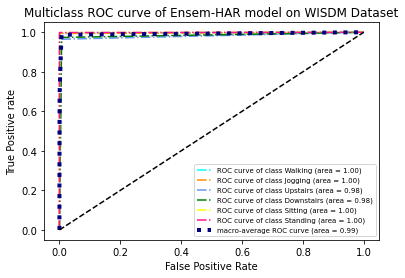

In [44]:
from itertools import cycle
colors = cycle(["aqua", "darkorange", "cornflowerblue","green","yellow","deeppink"])
n_classes=['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']
for i,cls, color in zip(range(class_number),n_classes, colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linestyle='-.',
        label="ROC curve of class {0} (area = {1:0.2f})".format(cls, roc_auc[i]),
    )
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--")
plt.title('Multiclass ROC curve of Ensem-HAR model on WISDM Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right",prop={"size":7})

plt.savefig('Metrics//Multiclass_ROC_WISDM',dpi=1200, bbox_inches='tight')    

## Comparison of various performance metrics(accuracy,precision,recall,f1-score) between the Basemodels and the Ensembler

In [45]:
predy_m1=model1.predict([X_test,X_test,X_test,X_test])
predy_m1=np.argmax(predy_m1, axis=-1)
predy_m2=model2.predict([X_test,X_test,X_test,X_test,X_test])
predy_m2=np.argmax(predy_m2, axis=-1)
predy_m3=model3.predict(X_test3)
predy_m3=np.argmax(predy_m3, axis=-1)
predy_m4=model4.predict(X_test)
predy_m4=np.argmax(predy_m4, axis=-1)
predy_en=EnsemHAR.predict(stackX_test)

In [46]:
#all models predictions
model_pred=[predy_m1,predy_m2,predy_m3,predy_m4,predy_en]


In [47]:
model_acc={}
models=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']
i=0
for pred,model in zip(model_pred,models):
    model_acc[model]=acc(y_test,pred)*100

In [48]:
print(model_acc)

{'CNN-net': 96.61528150134048, 'CNN_LSTM-net': 97.83847184986595, 'ConvLSTM-net': 97.3274128686327, 'Stacked_LSTM-net': 98.60924932975871, 'Ensem-HAR': 98.70140750670241}


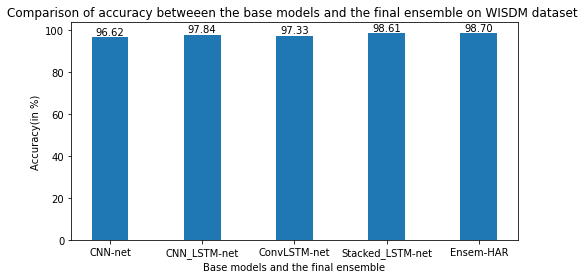

In [50]:
fig = plt.figure(figsize=(8,4))
plt.bar(model_acc.keys(),model_acc.values(),width=0.4)
y=list(model_acc.values())
plt.xlabel("Base models and the final ensemble")
plt.ylabel("Accuracy(in %)")
plt.title("Comparison of accuracy betweeen the base models and the final ensemble on WISDM dataset ")
for i in range(5):
    plt.text(i,y[i],"{0:0.2f}".format(y[i]),ha="center",va="bottom")
plt.savefig('Metrics//accuracy_comparison',dpi=1200, bbox_inches='tight')    

In [75]:
pre=np.empty((0,6))
re=np.empty((0,6))
f1_=np.empty((0,6))
for predy in model_pred:
    precision=skm.precision_score(y_test, predy, average=None)
    pre=np.vstack([pre,precision])
    recall=skm.recall_score(y_test, predy, average=None)
    re=np.vstack([re,recall])
    f1=skm.f1_score(y_test, predy, average=None)
    f1_=np.vstack([f1_,f1])

In [78]:
df_pre=pd.DataFrame(pre)
df_pre.columns=['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']
df_pre.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']
df_re=pd.DataFrame(re)
df_re.columns=['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']
df_re.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']
df_f1=pd.DataFrame(f1_)
df_f1.columns=['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing']
df_f1.index=['CNN-net','CNN_LSTM-net','ConvLSTM-net','Stacked_LSTM-net','Ensem-HAR']

In [80]:
df_pre.to_csv('Precision.csv')
df_re.to_csv('Recall.csv')
df_f1.to_csv('f1_score.csv')

### Comparison with Basic Ensemble Techniques like 'Max Voting', 'Averaging', 'Weighted Average'

#### Max Voting

In [15]:
import seaborn as sns
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report

In [14]:
predy_m1=model1.predict([X_test,X_test,X_test,X_test])
predy_m1=np.argmax(predy_m1, axis=-1)
predy_m2=model2.predict([X_test,X_test,X_test,X_test,X_test])
predy_m2=np.argmax(predy_m2, axis=-1)
predy_m3=model3.predict(X_test3)
predy_m3=np.argmax(predy_m3, axis=-1)
predy_m4=model4.predict(X_test)
predy_m4=np.argmax(predy_m4, axis=-1)

In [29]:
pred=[predy_m1,predy_m2,predy_m3,predy_m4]
all_Accuracy = []
for predy in pred:
    all_Accuracy.append(acc(y_test,predy))

In [31]:
def GetVotingClassifier(m1P,m2P,m3P,m4P,all_acc):
    Total_Predict = []
    for i in range(len(m1P)):
        Total_Predict.append([m1P[i],m2P[i],m3P[i],m4P[i]])

    return Total_Predict


In [32]:
pr=GetVotingClassifier(predy_m1,predy_m2,predy_m3,predy_m4,all_Accuracy)

In [37]:
Total_Predict = []
for i in range(len(predy_m1)):
    Total_Predict.append([predy_m1[i],predy_m2[i],predy_m3[i],predy_m4[i]])


In [47]:
Total_Predict

[[4, 4, 4, 4],
 [3, 3, 3, 3],
 [2, 2, 2, 2],
 [5, 5, 5, 5],
 [1, 1, 1, 1],
 [3, 3, 3, 3],
 [2, 2, 2, 2],
 [1, 1, 1, 1],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [5, 5, 5, 5],
 [4, 4, 4, 4],
 [2, 2, 2, 2],
 [1, 1, 1, 1],
 [2, 2, 2, 2],
 [2, 2, 2, 2],
 [5, 5, 5, 5],
 [0, 0, 0, 0],
 [3, 3, 3, 3],
 [5, 5, 5, 5],
 [2, 2, 2, 2],
 [5, 5, 5, 5],
 [4, 4, 4, 4],
 [1, 1, 1, 1],
 [4, 4, 4, 4],
 [5, 5, 5, 5],
 [1, 1, 1, 1],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [2, 2, 2, 2],
 [3, 3, 3, 3],
 [4, 4, 4, 4],
 [1, 1, 1, 1],
 [3, 3, 2, 3],
 [4, 4, 4, 4],
 [4, 4, 4, 4],
 [0, 0, 0, 0],
 [3, 3, 3, 3],
 [5, 5, 5, 5],
 [1, 1, 1, 1],
 [0, 0, 0, 0],
 [3, 3, 3, 3],
 [1, 1, 1, 1],
 [5, 5, 5, 5],
 [2, 2, 2, 2],
 [3, 3, 3, 3],
 [5, 5, 5, 5],
 [4, 4, 4, 4],
 [3, 3, 3, 3],
 [5, 5, 5, 5],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [3, 3, 3, 3],
 [3, 3, 3, 3],
 [4, 4, 4, 4],
 [0, 0, 0, 0],
 [5, 5, 5, 5],
 [3, 3, 3, 3],
 [4, 4, 4, 4],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [1, 1, 1, 1],
 [4, 4, 4, 4],
 [4, 4, 4, 4],
 [5, 5, 5, 5],
 [5, 5, 5, 5],
 [5, 5, 5,

In [45]:
VoteY = []

for i in range(len(predy_m1)):
    VoteForOne = np.zeros([6,1])
    for j in range(4):
        VoteForOne[Total_Predict[i][j]]+=all_Accuracy[j] # Adding accuracy based on predicted Y
    FinalVote = np.argmax(VoteForOne) # Returns index of maximum row
    VoteY.append(FinalVote)

In [46]:
VoteY 

[4,
 3,
 2,
 5,
 1,
 3,
 2,
 1,
 0,
 0,
 5,
 4,
 2,
 1,
 2,
 2,
 5,
 0,
 3,
 5,
 2,
 5,
 4,
 1,
 4,
 5,
 1,
 0,
 0,
 2,
 3,
 4,
 1,
 3,
 4,
 4,
 0,
 3,
 5,
 1,
 0,
 3,
 1,
 5,
 2,
 3,
 5,
 4,
 3,
 5,
 1,
 1,
 3,
 3,
 4,
 0,
 5,
 3,
 4,
 0,
 0,
 1,
 4,
 4,
 5,
 5,
 5,
 3,
 4,
 4,
 0,
 4,
 1,
 4,
 2,
 3,
 1,
 1,
 3,
 0,
 4,
 5,
 0,
 4,
 2,
 1,
 2,
 5,
 0,
 3,
 3,
 4,
 5,
 4,
 2,
 3,
 0,
 1,
 2,
 3,
 2,
 5,
 0,
 0,
 1,
 3,
 5,
 4,
 1,
 1,
 2,
 0,
 5,
 1,
 5,
 5,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 2,
 3,
 4,
 3,
 5,
 4,
 2,
 4,
 5,
 5,
 3,
 0,
 5,
 0,
 0,
 1,
 1,
 4,
 1,
 0,
 0,
 5,
 0,
 1,
 2,
 3,
 4,
 3,
 5,
 2,
 1,
 2,
 4,
 5,
 3,
 0,
 0,
 2,
 5,
 5,
 5,
 2,
 2,
 5,
 0,
 3,
 3,
 2,
 1,
 5,
 1,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 3,
 3,
 4,
 1,
 3,
 1,
 1,
 5,
 4,
 1,
 0,
 1,
 0,
 1,
 2,
 5,
 4,
 1,
 1,
 2,
 4,
 3,
 0,
 1,
 3,
 2,
 0,
 1,
 5,
 3,
 5,
 4,
 1,
 0,
 2,
 4,
 0,
 4,
 0,
 0,
 0,
 5,
 5,
 2,
 4,
 1,
 4,
 1,
 5,
 2,
 3,
 4,
 5,
 5,
 2,
 3,
 3,
 5,
 0,
 2,
 4,
 4,
 2,
 1,
 0,
 5,
 2,
 3,


In [38]:
sample_X=[]
sample_y=[]
#creating 10 sample dataset of size 50 from the test data
for i in range(10):
    demo_X=np.empty((50,128,39))
    demo_y=np.empty(50)
    demo_X=X_test[(i*200):(i*200)+50]#each sample
    demo_y=y_test[(i*200):(i*200)+50]
    sample_X.append(demo_X)# appending to the list of samples
    sample_y.append(demo_y)


In [39]:
len(sample_X)

10

In [40]:
# accuracy of each base models and ensemble on 10 sample dataset of size 50 taken from the test data
m1_acc=[]
m2_acc=[]
m3_acc=[]
m4_acc=[]
ensem_acc=[]

for sample,y_testSample in zip(sample_X,sample_y):
    stackSamp=None
    predy_m1=model1.predict([sample,sample,sample,sample])
    predy_m1=np.argmax(predy_m1, axis=-1)
    m1_acc.append(acc(predy_m1,y_testSample))

    stackSamp=predy_m1
    
    predy_m2=model2.predict([sample,sample,sample,sample,sample])
    predy_m2=np.argmax(predy_m2, axis=-1)
    m2_acc.append(acc(predy_m2,y_testSample))

    stackSamp=dstack((predy_m2,stackSamp))
    
    sample3 = sample.reshape((sample.shape[0], n_steps, n_length,n_features))
    predy_m3=model3.predict(sample3)
    predy_m3=np.argmax(predy_m3, axis=-1)
    m3_acc.append(acc(predy_m3,y_testSample))

    stackSamp=dstack((predy_m3,stackSamp))
    
    predy_m4=model4.predict(sample)
    predy_m4=np.argmax(predy_m4, axis=-1)
    m4_acc.append(acc(predy_m4,y_testSample))

    stackSamp=dstack((predy_m4,stackSamp))
    
    stackSamp = stackSamp.reshape((stackSamp.shape[0]*stackSamp.shape[1],stackSamp.shape[2]))
    predy_en=EnsemHAR.predict(stackSamp)
    ensem_acc.append(acc(predy_en,y_testSample))

In [41]:
ranking=pd.DataFrame()
ranking['CNN-net']=m1_acc
ranking['CNN_LSTM-net']=m2_acc
ranking['ConvLSTM-net']=m3_acc
ranking['Stacked_LSTM-net']=m4_acc
ranking['Ensem-HAR']=ensem_acc

In [43]:
ranking.to_csv('accuracies.csv')